In [1]:
import os
import time
import glob
import tables as tb
import numpy  as np
import pandas as pd

from invisible_cities.core.system_of_units import year, kg, dalton
from invisible_cities.evm.mixer import get_mixer_nevents

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit
import hist

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


## Load PDFs

In [2]:
def create_pdf_from_histogram(bins, histo, obs, name):
    h    = hist.Hist(hist.axis.Variable(edges=bins, name=name), data=histo)
    pdf  = zfit.pdf.HistogramPDF(h)
    data = zfit.Data.from_numpy (obs=obs, array=binc, weights=h)
    pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=data, bandwidth=np.mean(np.diff(bins)))
    return pdf

In [3]:
data_filename = "./create_pdfs/selected_data_typeII.h5"

# create pdfs
with tb.open_file(data_filename) as h5file:
    
    # energy pdfs
    name = "energy"
    bins = h5file.root.energy.bins.read()
    binc = (bins[1:] + bins[:-1])/2.
    emin, emax = bins[0], bins[-1]
    energy_obs = zfit.Space(name, limits=(emin, emax))
    
    h = h5file.root.energy.bb0nu.read()
    pdf_energy_bb = create_pdf_from_histogram(bins, h, energy_obs, name)
    h = h5file.root.energy.Bi.read()
    pdf_energy_Bi = create_pdf_from_histogram(bins, h, energy_obs, name)
    h = h5file.root.energy.Tl.read()
    pdf_energy_Tl = create_pdf_from_histogram(bins, h, energy_obs, name)
    
    # eblob2
    name = "eblob2"
    bins = h5file.root.eblob2.bins.read()
    binc = (bins[1:] + bins[:-1])/2.
    eb2min, eb2max = bins[0], bins[-1]
    eblob2_obs     = zfit.Space(name, limits=(eb2min, eb2max))
    
    h = h5file.root.eblob2.bb0nu.read()
    pdf_eblob2_bb = create_pdf_from_histogram(bins, h, eblob2_obs, name)
    h = h5file.root.eblob2.Bi.read()
    pdf_eblob2_Bi = create_pdf_from_histogram(bins, h, eblob2_obs, name)
    h = h5file.root.eblob2.Tl.read()
    pdf_eblob2_Tl = create_pdf_from_histogram(bins, h, eblob2_obs, name)
    
    
pdf_bb = zfit.pdf.ProductPDF([pdf_energy_bb, pdf_eblob2_bb])
pdf_Tl = zfit.pdf.ProductPDF([pdf_energy_Tl, pdf_eblob2_Tl])
pdf_Bi = zfit.pdf.ProductPDF([pdf_energy_Bi, pdf_eblob2_Bi])

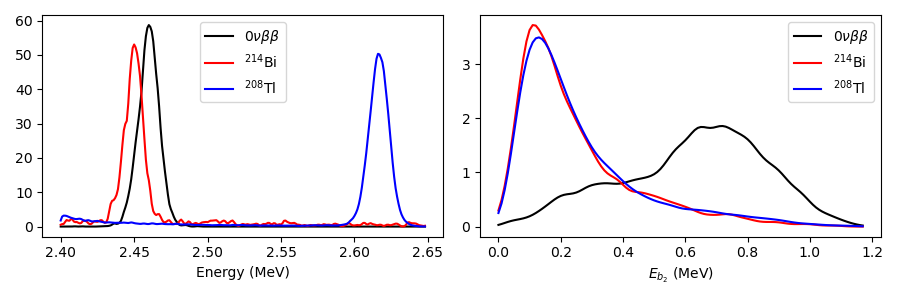

In [4]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel("Energy (MeV)")
plt.legend()

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.01)
plt.plot(E, pdf_eblob2_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()

plt.tight_layout()

## Generate random experiment

In [5]:
T12_0nubb  = 2.e+26 * year
enrichment = 0.9
xenon_mass = 100. * kg
exposure   = 4. * year
detector_db = "next100"
isotopes = ["208Tl", "214Bi", "0nubb"]

# ic efficiencies
eff_ic = pd.read_csv("efficiencies_ic.csv").set_index(["Isotope", "G4Volume"])
# selection efficiencies
# eff_sel = pd.read_csv("efficiencies_selection.csv").set_index(["Isotope", "G4Volume"])
eff_sel = pd.read_hdf(data_filename, "efficiencies")
# efficiency
total_eff = ((eff_ic.nreco/eff_ic.nsim) * (eff_sel.nevts/eff_ic.nreco)).fillna(0).loc[isotopes].sort_index()

N0 = enrichment*(xenon_mass/(136. * dalton))

# get event df with (g4volume, isotope, nevts)
nevent_df = get_mixer_nevents(exposure, detector_db, isotopes)

# get number of decays of signal-like events
if "0nubb" in isotopes:
    nevts = N0 * (np.log(2)/T12_0nubb) * exposure
    nevent_df.loc[len(nevent_df)] = ("ACTIVE", "0nubb", nevts)

nevent_df = nevent_df.set_index(["Isotope", "G4Volume"]).sort_index()
    
# assert sorted indexes
indexes = total_eff.index
assert (indexes == nevent_df.index).all()

In [6]:
# randomize (binomial)
nevents = np.random.binomial(nevent_df.nevts, total_eff)
nevents_roi = pd.DataFrame(index=indexes, data={"nevts": nevents})
nevents = nevents_roi.groupby(level=0).nevts.sum()
print(nevents)

Isotope
0nubb       2
208Tl    5853
214Bi     173
Name: nevts, dtype: int64


In [7]:
t0 = time.time()

sample = np.concatenate([ pdf_bb.sample(nevents.get("0nubb")).numpy()
                        , pdf_Tl.sample(nevents.get("208Tl")).numpy()
                        , pdf_Bi.sample(nevents.get("214Bi")).numpy()])

print("Time (s):", time.time()-t0)

Time (s): 3.8781721591949463


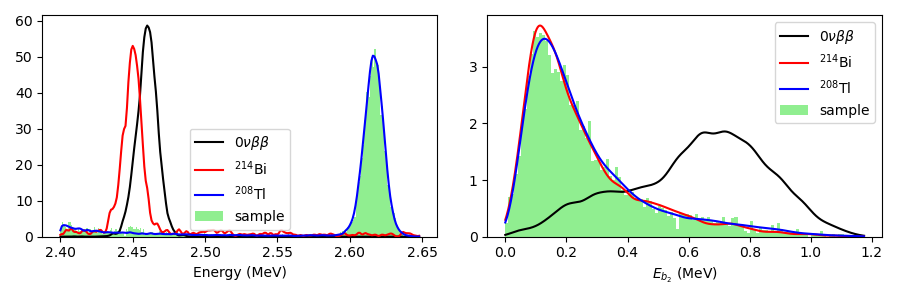

In [8]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_Tl.pdf(E), color="b", label=r"$^{208}$Tl")

bins = np.arange(*energy_obs.limit1d, 0.001)
plt.hist(sample[:, 0], bins=bins, color="lightgreen", label="sample", density=True)
plt.xlabel("Energy (MeV)")
plt.legend()

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.001)
plt.plot(E, pdf_eblob2_bb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_Tl.pdf(E), color="b", label=r"$^{208}$Tl")

bins = np.arange(*eblob2_obs.limit1d, 0.01)
plt.hist(sample[:, 1], bins=bins, color="lightgreen", label="sample", density=True)
plt.xlabel(r"$E_{b_2}$ (MeV)")
plt.legend()

plt.tight_layout()

## Fit

In [9]:
# RUN ONCE!!
N = int(10*nevent_df.nevts.sum())
nbb = zfit.Parameter("nbb", 1, 0, N)
nTl = zfit.Parameter("nTl", 1, 0, N)
nBi = zfit.Parameter("nBi", 1, 0, N)

pdf_bb.set_yield(nbb)
pdf_Tl.set_yield(nTl)
pdf_Bi.set_yield(nBi)

In [10]:
model = zfit.pdf.SumPDF(pdfs=[pdf_bb, pdf_Tl, pdf_Bi])

# minimizer
minimizer = zfit.minimize.Minuit(gradient=True)

In [11]:
# obs = energy_obs * eblob2_obs
# data = zfit.Data.from_numpy(obs=obs, array=np.stack((energy, eblob2), axis=1))

t0 = time.time()
sample = np.concatenate([ pdf_bb.sample(nevents.get("0nubb")).numpy()
                        , pdf_Tl.sample(nevents.get("208Tl")).numpy()
                        , pdf_Bi.sample(nevents.get("214Bi")).numpy()])

data = zfit.Data.from_numpy(obs=energy_obs * eblob2_obs, array=sample)

print("Time (s):", time.time()-t0)

Time (s): 2.322448968887329


In [14]:
t0 = time.time()

# loss
nll = zfit.loss.ExtendedUnbinnedNLL(model, data)
nll.create_new()

# fit
result = minimizer.minimize(nll)

# error
# errors, _ = result.errors(method="hesse")
param_hesse = result.hesse()

print("Valid:", result.valid)
print(result.params)

print("Time (min):", (time.time()-t0) / 60)

Valid: True
name          hesse    value    at limit
------  -----------  -------  ----------
nbb     +/-     6.1  1.68387       False
nTl     +/-      78  5828.08       False
nBi     +/-      22  198.274       False
Time (min): 0.0760293165842692


## Pulls

$$X = \frac{n_{\text{fit}} - n_{\text{true}}}{s(n_{\text{fit}})}$$

In [12]:
filenames = sorted(glob.glob("./results/*.csv"))
df = pd.concat([pd.read_csv(filename) for filename in filenames])

In [13]:
# gaussian fit
mu    = zfit.Parameter(   "mu", 0, -10, 10)
sigma = zfit.Parameter("sigma", 1,   0, 10)

obs   = zfit.Space('p', limits=(-10, 10))
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)
minimizer = zfit.minimize.Minuit()

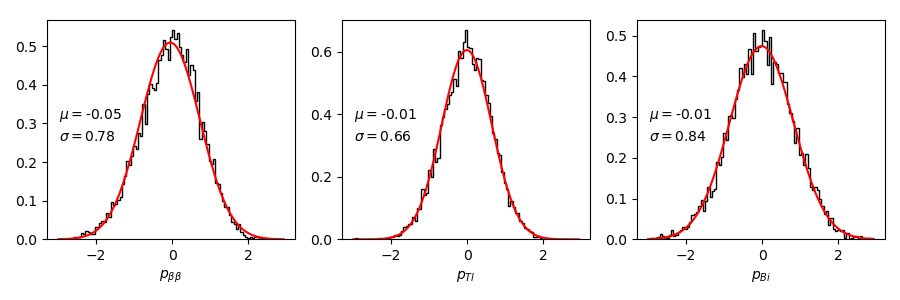

In [14]:
plt.figure(figsize=[9, 3])

bins = np.arange(-3., 3., 0.06)

# 0nubb
plt.subplot(131)
p = ((df.nbb - df.nbbt) / df.sbb).values
data = zfit.Data.from_numpy(obs=obs, array=p)
nll  = zfit.loss.UnbinnedNLL(model=gauss, data=data)
result = minimizer.minimize(nll)
result.hesse()

plt.hist(p, bins=bins, histtype="step", color="k", density=True)
plt.plot(bins, gauss.pdf(bins), color="r")
plt.annotate(r"$\mu = $"    + str(round(result.params[   "mu"]["value"], 2)), (0.05, 0.55), xycoords="axes fraction")
plt.annotate(r"$\sigma = $" + str(round(result.params["sigma"]["value"], 2)), (0.05, 0.45), xycoords="axes fraction")
plt.xlabel(r"$p_{\beta\beta}$")

plt.subplot(132)
p = ((df.nTl - df.nTlt) / df.sTl).values
data = zfit.Data.from_numpy(obs=obs, array=p)
nll  = zfit.loss.UnbinnedNLL(model=gauss, data=data)
result = minimizer.minimize(nll)
result.hesse()

plt.hist(p, bins=bins, histtype="step", color="k", density=True)
plt.plot(bins, gauss.pdf(bins), color="r")
plt.annotate(r"$\mu = $"    + str(round(result.params[   "mu"]["value"], 2)), (0.05, 0.55), xycoords="axes fraction")
plt.annotate(r"$\sigma = $" + str(round(result.params["sigma"]["value"], 2)), (0.05, 0.45), xycoords="axes fraction")
plt.xlabel(r"$p_{Tl}$")


plt.subplot(133)
p = ((df.nBi - df.nBit) / df.sBi).values
data = zfit.Data.from_numpy(obs=obs, array=p)
nll  = zfit.loss.UnbinnedNLL(model=gauss, data=data)
result = minimizer.minimize(nll)
result.hesse()

plt.hist(p, bins=bins, histtype="step", color="k", density=True)
plt.plot(bins, gauss.pdf(bins), color="r")
plt.annotate(r"$\mu = $"    + str(round(result.params[   "mu"]["value"], 2)), (0.05, 0.55), xycoords="axes fraction")
plt.annotate(r"$\sigma = $" + str(round(result.params["sigma"]["value"], 2)), (0.05, 0.45), xycoords="axes fraction")
plt.xlabel(r"$p_{Bi}$")

plt.tight_layout();

## Correlations

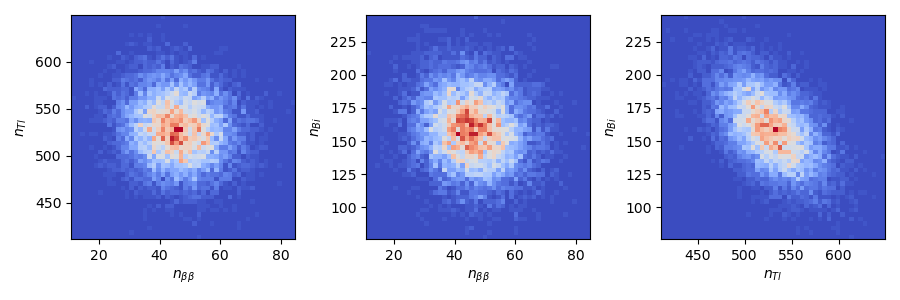

In [37]:
plt.figure(figsize=[9, 3])

plt.subplot(131)
plt.hist2d(df.nbb, df.nTl, bins=50, cmap="coolwarm")
plt.xlabel(r"$n_{\beta\beta}$")
plt.ylabel(r"$n_{Tl}$")

plt.subplot(132)
plt.hist2d(df.nbb, df.nBi, bins=50, cmap="coolwarm")
plt.xlabel(r"$n_{\beta\beta}$")
plt.ylabel(r"$n_{Bi}$")

plt.subplot(133)
plt.hist2d(df.nTl, df.nBi, bins=50, cmap="coolwarm")
plt.xlabel(r"$n_{Tl}$")
plt.ylabel(r"$n_{Bi}$")

plt.tight_layout();

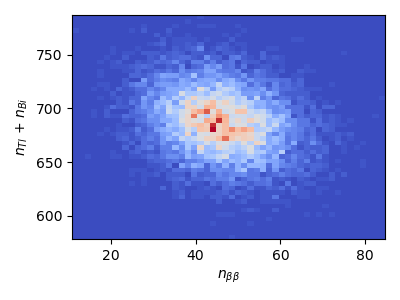

In [41]:
plt.figure(figsize=[4, 3])

plt.hist2d(df.nbb, (df.nTl + df.nBi), bins=50, cmap="coolwarm")
plt.xlabel(r"$n_{\beta\beta}$")
plt.ylabel(r"$n_{Tl}$ + $n_{Bi}$")
plt.tight_layout()